In [1]:
import json
import os

import numpy as np
import cv2

import _init_paths
# import cv2
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import Evaluator
from utils import *

from math import ceil
from matplotlib import pyplot as plt

In [2]:
def parse(dataset, detected):
    parsed_boxes = BoundingBoxes()
    for i, data in enumerate(dataset):
        key = str(i) + '.jpg'
        # Ground-truth
        for bbox in data:
            imsize = (bbox['imageWidth'], bbox['imageHeight'])
            val = bbox['points']
            tmp = BoundingBox(imageName=key,
                                classId='Face',
                                x=ceil(val[0]['x'] * bbox['imageWidth']),
                                y=ceil(val[0]['y'] * bbox['imageHeight']),
                                w=ceil(val[1]['x'] * bbox['imageWidth']),
                                h=ceil(val[1]['y'] * bbox['imageHeight']),
                                typeCoordinates=CoordinatesType.Absolute,
                                bbType=BBType.GroundTruth,
                                imgSize=imsize,
                                format=BBFormat.XYX2Y2)
            parsed_boxes.addBoundingBox(tmp)
        # Detected
        for bbox in detected[key]:
            tmp = BoundingBox(imageName=key,
                                classId='Face',
                                classConfidence=1.0,
                                x=bbox[0],
                                y=bbox[1],
                                w=bbox[2],
                                h=bbox[3],
                                typeCoordinates=CoordinatesType.Absolute,
                                bbType=BBType.Detected,
                                imgSize=imsize,
                                format=BBFormat.XYWH)
            parsed_boxes.addBoundingBox(tmp)
    return parsed_boxes

In [5]:
inp_file = 'data/face_detection.json'
inp_dir = os.path.dirname(inp_file)

p = []
r = []

dataset = []
with open(inp_file, 'r') as json_file:
    for jf in json_file:
        jf = jf.replace('\n', '')
        jf = jf.strip()
        inp_data = json.loads(jf)
        dataset.append(inp_data['annotation'])
        
for model in ['mtcnn', 'haar', 'hog', 'cvlib']:
    print(model)
    with open('data/{}.json'.format(model), 'r') as json_file:
        detected = json.loads(json_file.read())
    parsed_boxes = parse(dataset,detected)
    
    
    m = Evaluator().GetPascalVOCMetrics(parsed_boxes, IOUThreshold=0.4)[0]
    print("AP", m['AP'])
    print("Correctly detected (TP)", m['total TP'])
    print("Incorrectly detected (FP)", m['total FP'])
    print("All faces", m['total positives'])
    print()
    p.append(m['precision'])
    r.append(m['recall'])
    
print("* here cvlib is YOLOv3 model")

mtcnn
AP 0.4605013815876405
Correctly detected (TP) 722.0
Incorrectly detected (FP) 321.0
All faces 1132

haar
AP 0.44748801256606163
Correctly detected (TP) 605.0
Incorrectly detected (FP) 138.0
All faces 1132

hog
AP 0.48847408855143887
Correctly detected (TP) 651.0
Incorrectly detected (FP) 137.0
All faces 1132

cvlib
AP 0.6595285886484105
Correctly detected (TP) 862.0
Incorrectly detected (FP) 160.0
All faces 1132

* here cvlib is YOLOv3 model


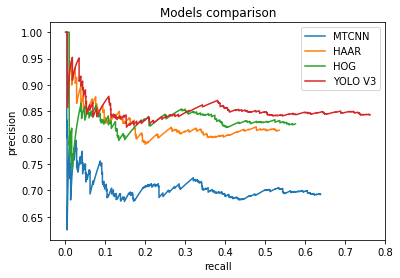

In [9]:
names = ['mtcnn', 'haar', 'hog', 'yolo v3']
for i, pres in enumerate(p):
    plt.plot(r[i], pres, label=names[i].upper())

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.title('Models comparison')
plt.show()

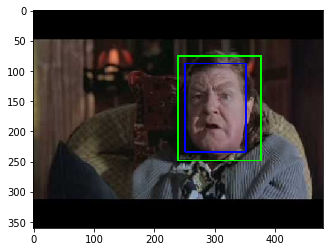

Image 20.jpg


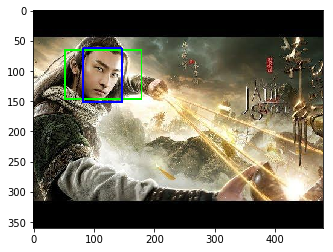

Image 21.jpg


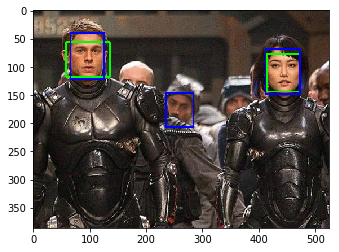

Image 22.jpg


In [15]:
start = 20
n_photos = 3
for i in range(start, start + n_photos):
    image_name = str(i) + '.jpg'
    image_path = "data/detection_metrics_dataset/" + image_name
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Add bounding boxes
    im = parsed_boxes.drawAllBoundingBoxes(im, image_name)
    plt.imshow(im)
    plt.show()
#     cv2.imshow(image_path, im)
#     cv2.waitKey(0)
#     cv2.imwrite(str(i) + '.jpg', im)
    print('Image %s' % image_name)